In [86]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

%matplotlib inline
import matplotlib.pyplot as plt

from tqdm import tqdm

**Перед тем как начать выполнять задание, определитесь где вы будете обучать модель: на GPU или CPU.**

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Проблема затухания градиента

Рассмотрим проблему затухания градиента во время обучений неройнных сетей

**Залача 1:** Определите модель со следующей структурой:
1. Вход и выход заданы - линейными слоями (nn.Linear)
2. Скрытые слои - в виде линейных слоев в nn.ModuleList

In [115]:
# Класс модели:
class DeepMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_hidden):
        super(DeepMLP, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_hidden)])
        self.output_layer = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.input_layer(x)
        for hidden_layer in self.hidden_layers:
            x = F.sigmoid(hidden_layer(x))
        x = self.output_layer(x)
        return x


**Вопрос:** Сколько параметров (весов) будет иметь эта модель, если инициализировать ее следующие аргументами:

input_size=3, 
hidden_size=6,
output_size=7,
n_hidden=1

**Пример ответа:** `123`

In [120]:
model = DeepMLP(input_size=3, hidden_size=6, output_size=7, n_hidden=1)

answer = sum(p.numel() for p in model.parameters() if p.requires_grad)
answer   ### здесь должен быть выведен ответ

115

**Задача 2:** Вычислите среднее по градиенту в первом скрытом (!!!) слое.

**Вопрос:** Каково это значение?

**Пример ответа:** `1.2`

In [139]:
torch.manual_seed(42)

model = DeepMLP(28 * 28, 6, 7, 1)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer.zero_grad()
out = model(torch.rand((1, 28 * 28)))
loss = criterion(out, torch.rand((1, )).long())

loss.backward()

In [141]:
answer  = torch.mean(model.hidden_layers[0].weight.grad).item()
answer   ### здесь должен быть выведен ответ

0.0010385029017925262

Теперь попробуйте обучить небольшую модель состоящую всего-лишь из трех скрытых слоев.

**Задача 3:** Создайте объект класса модели DeepMLP

In [61]:
torch.manual_seed(42)

# Инициализация модели, лосс функции и оптимайзера:
input_size = 28 * 28 # MNIST image size
hidden_size = 32
output_size = 10
n_hidden=3          # небольшая модель всего из трех скрытых слоев
model = DeepMLP(input_size, hidden_size, output_size, n_hidden).to(device)

**Вопрос:** Какова сумма всех выходов модели для случайного входного тензора test_data?

**Пример ответа:** `1.234`

In [131]:
test_data = torch.rand((1, 28*28)).to(device)

answer = model(test_data).sum()
answer   ### здесь должен быть выведен ответ

tensor(-1.1736, grad_fn=<SumBackward0>)

Теперь попробуем имплементировать цикл обучения и затем обучить модель на датасете MNIST. Но для начала давайте скачаем и подготовим этот датасет для обучения:

In [63]:
# Загрузка и подготовка датасета MNIST:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

In [78]:
# Опишем цикл обучения:
def train(model, trainloader, criterion, optimizer):
  torch.manual_seed(42)

  model.train()

  fc_gradients = []

  for step, data in tqdm(enumerate(trainloader), total=len(trainloader)):
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      
      loss.backward()
      optimizer.step()

      if step % 10 == 0:
        print(f'Step: {step}, Loss: {loss}')

      fc_gradients.append([torch.mean(layer.weight.grad) for layer in model.hidden_layers])  # <------ код из решения задачи 2

  return fc_gradients

In [99]:
# Теперь обучим модель:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

_ = train(model, trainloader, criterion, optimizer)

  0%|          | 1/938 [00:03<59:43,  3.82s/it]

Step: 0, Loss: 2.3068506717681885


  3%|▎         | 28/938 [00:04<01:05, 13.90it/s]

Step: 10, Loss: 2.2990219593048096
Step: 20, Loss: 2.2969326972961426
Step: 30, Loss: 2.307311534881592


  7%|▋         | 66/938 [00:04<00:19, 45.20it/s]

Step: 40, Loss: 2.311021089553833
Step: 50, Loss: 2.309307813644409
Step: 60, Loss: 2.299656629562378


 10%|▉         | 91/938 [00:04<00:12, 68.06it/s]

Step: 70, Loss: 2.294252872467041
Step: 80, Loss: 2.3101613521575928
Step: 90, Loss: 2.290330410003662


 12%|█▏        | 115/938 [00:05<00:09, 85.92it/s]

Step: 100, Loss: 2.308593511581421
Step: 110, Loss: 2.2963879108428955
Step: 120, Loss: 2.278615713119507


 15%|█▍        | 140/938 [00:05<00:07, 100.27it/s]

Step: 130, Loss: 2.2822210788726807
Step: 140, Loss: 2.291945457458496
Step: 150, Loss: 2.304619789123535


 19%|█▉        | 177/938 [00:05<00:06, 111.69it/s]

Step: 160, Loss: 2.294919013977051
Step: 170, Loss: 2.2919204235076904
Step: 180, Loss: 2.300417900085449


 21%|██▏       | 201/938 [00:05<00:06, 110.32it/s]

Step: 190, Loss: 2.3038790225982666
Step: 200, Loss: 2.293001890182495


 24%|██▍       | 225/938 [00:06<00:06, 110.02it/s]

Step: 210, Loss: 2.298564910888672
Step: 220, Loss: 2.318671941757202
Step: 230, Loss: 2.2953765392303467


 28%|██▊       | 261/938 [00:06<00:06, 109.93it/s]

Step: 240, Loss: 2.3185133934020996
Step: 250, Loss: 2.3007214069366455
Step: 260, Loss: 2.3094727993011475


 30%|███       | 285/938 [00:06<00:05, 112.60it/s]

Step: 270, Loss: 2.3052639961242676
Step: 280, Loss: 2.301408290863037
Step: 290, Loss: 2.301598310470581


 34%|███▍      | 321/938 [00:06<00:05, 113.05it/s]

Step: 300, Loss: 2.314304828643799
Step: 310, Loss: 2.2893872261047363
Step: 320, Loss: 2.30151104927063


 37%|███▋      | 345/938 [00:07<00:05, 112.23it/s]

Step: 330, Loss: 2.2941319942474365
Step: 340, Loss: 2.307159662246704
Step: 350, Loss: 2.3111894130706787


 41%|████      | 380/938 [00:07<00:05, 108.09it/s]

Step: 360, Loss: 2.279991626739502
Step: 370, Loss: 2.3011929988861084
Step: 380, Loss: 2.30420184135437


 43%|████▎     | 404/938 [00:07<00:04, 108.34it/s]

Step: 390, Loss: 2.303403377532959
Step: 400, Loss: 2.319448709487915
Step: 410, Loss: 2.3046019077301025


 47%|████▋     | 440/938 [00:07<00:04, 109.74it/s]

Step: 420, Loss: 2.3087854385375977
Step: 430, Loss: 2.3014395236968994
Step: 440, Loss: 2.3062169551849365


 49%|████▉     | 464/938 [00:08<00:04, 109.28it/s]

Step: 450, Loss: 2.3104088306427
Step: 460, Loss: 2.2988741397857666
Step: 470, Loss: 2.2997848987579346


 53%|█████▎    | 500/938 [00:08<00:03, 113.03it/s]

Step: 480, Loss: 2.287132501602173
Step: 490, Loss: 2.3007571697235107
Step: 500, Loss: 2.305788278579712


 56%|█████▌    | 524/938 [00:08<00:03, 110.35it/s]

Step: 510, Loss: 2.306150197982788
Step: 520, Loss: 2.2967817783355713
Step: 530, Loss: 2.298297882080078


 60%|█████▉    | 560/938 [00:09<00:03, 112.00it/s]

Step: 540, Loss: 2.302319049835205
Step: 550, Loss: 2.3007700443267822
Step: 560, Loss: 2.2945191860198975


 62%|██████▏   | 584/938 [00:09<00:03, 114.17it/s]

Step: 570, Loss: 2.3120198249816895
Step: 580, Loss: 2.3071846961975098
Step: 590, Loss: 2.3136205673217773


 66%|██████▌   | 620/938 [00:09<00:02, 111.37it/s]

Step: 600, Loss: 2.295316696166992
Step: 610, Loss: 2.3204314708709717


 69%|██████▊   | 644/938 [00:09<00:02, 111.34it/s]

Step: 620, Loss: 2.2999510765075684
Step: 630, Loss: 2.3112902641296387
Step: 640, Loss: 2.280841112136841


 71%|███████   | 668/938 [00:10<00:02, 109.49it/s]

Step: 650, Loss: 2.2984039783477783
Step: 660, Loss: 2.3057451248168945
Step: 670, Loss: 2.291989326477051


 74%|███████▎  | 691/938 [00:10<00:02, 111.20it/s]

Step: 680, Loss: 2.3120529651641846
Step: 690, Loss: 2.302473783493042
Step: 700, Loss: 2.302300214767456


 77%|███████▋  | 726/938 [00:10<00:01, 107.64it/s]

Step: 710, Loss: 2.2988202571868896
Step: 720, Loss: 2.3168423175811768
Step: 730, Loss: 2.30643367767334


 81%|████████  | 760/938 [00:10<00:01, 106.07it/s]

Step: 740, Loss: 2.2940938472747803
Step: 750, Loss: 2.295836925506592


 83%|████████▎ | 783/938 [00:11<00:01, 108.79it/s]

Step: 760, Loss: 2.3014464378356934
Step: 770, Loss: 2.317411422729492
Step: 780, Loss: 2.2927722930908203


 86%|████████▌ | 805/938 [00:11<00:01, 108.27it/s]

Step: 790, Loss: 2.295131206512451
Step: 800, Loss: 2.295879602432251
Step: 810, Loss: 2.3132164478302


 89%|████████▉ | 838/938 [00:11<00:00, 105.35it/s]

Step: 820, Loss: 2.309333324432373
Step: 830, Loss: 2.3142309188842773
Step: 840, Loss: 2.3107900619506836


 92%|█████████▏| 862/938 [00:11<00:00, 107.19it/s]

Step: 850, Loss: 2.3054637908935547
Step: 860, Loss: 2.3025946617126465
Step: 870, Loss: 2.286362648010254


 96%|█████████▌| 896/938 [00:12<00:00, 107.43it/s]

Step: 880, Loss: 2.2970170974731445
Step: 890, Loss: 2.3038814067840576
Step: 900, Loss: 2.3018972873687744


 99%|█████████▉| 929/938 [00:12<00:00, 106.09it/s]

Step: 910, Loss: 2.297525644302368
Step: 920, Loss: 2.2962160110473633
Step: 930, Loss: 2.297441244125366


100%|██████████| 938/938 [00:13<00:00, 68.68it/s] 


Как вы можете видеть, модель сходится, хотя и не очень хорошо. Вы должны получить лосс в диапазоне 0.5-0.9. Низкая производительность модели обусловлена тем, что трех скрытых слоев недостаточно чтобы хорошо обучить эту модель классифицировать MNIST датасет.

Теперь попробуйте увеличить количество скрытых слоев до 10 и обучить модель еще раз.

**Задача 4:** Увеличьте число скрытых слоев до 10.

In [80]:
torch.manual_seed(42)

# Инициализация модели, лосс функции и оптимайзера:
input_size = 28 * 28 # MNIST image size
hidden_size = 32
output_size = 10
n_hidden = 10
model = DeepMLP(input_size, hidden_size, output_size, n_hidden).to(device)

**Вопрос:** Посчитайте и выведите количество скрытых слоев модели.

**Пример ответа:** `3`

In [83]:
answer = len(model.hidden_layers)
answer   ### здесь должен быть выведен ответ

10

In [84]:
# Обучите модель еще раз:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

fc_gradients = train(model, trainloader, criterion, optimizer)

  0%|          | 1/938 [00:03<58:28,  3.74s/it]

Step: 0, Loss: 2.3116233348846436


  3%|▎         | 26/938 [00:04<01:09, 13.04it/s]

Step: 10, Loss: 2.2927768230438232
Step: 20, Loss: 2.3289730548858643
Step: 30, Loss: 2.3101611137390137


  6%|▋         | 60/938 [00:04<00:21, 40.87it/s]

Step: 40, Loss: 2.3166162967681885
Step: 50, Loss: 2.334524154663086


  8%|▊         | 72/938 [00:04<00:16, 52.48it/s]

Step: 60, Loss: 2.3023855686187744
Step: 70, Loss: 2.3015942573547363
Step: 80, Loss: 2.3111732006073


 12%|█▏        | 108/938 [00:05<00:10, 78.44it/s]

Step: 90, Loss: 2.2828004360198975
Step: 100, Loss: 2.3095765113830566
Step: 110, Loss: 2.2963788509368896


 14%|█▍        | 130/938 [00:05<00:09, 88.98it/s]

Step: 120, Loss: 2.2688262462615967
Step: 130, Loss: 2.277372360229492
Step: 140, Loss: 2.292205810546875


 18%|█▊        | 165/938 [00:05<00:07, 100.29it/s]

Step: 150, Loss: 2.307490348815918
Step: 160, Loss: 2.305772542953491
Step: 170, Loss: 2.2927849292755127


 21%|██        | 198/938 [00:05<00:07, 104.14it/s]

Step: 180, Loss: 2.2967798709869385
Step: 190, Loss: 2.303372621536255
Step: 200, Loss: 2.2963035106658936


 23%|██▎       | 220/938 [00:06<00:07, 98.38it/s] 

Step: 210, Loss: 2.3021485805511475
Step: 220, Loss: 2.320111036300659


 26%|██▌       | 241/938 [00:06<00:07, 98.13it/s]

Step: 230, Loss: 2.2967655658721924
Step: 240, Loss: 2.3166935443878174


 29%|██▉       | 273/938 [00:06<00:07, 93.20it/s]

Step: 250, Loss: 2.300534963607788
Step: 260, Loss: 2.3093209266662598
Step: 270, Loss: 2.3047688007354736


 31%|███▏      | 295/938 [00:06<00:06, 97.92it/s]

Step: 280, Loss: 2.2988860607147217
Step: 290, Loss: 2.2999863624572754
Step: 300, Loss: 2.313730478286743


 35%|███▌      | 330/938 [00:07<00:05, 104.38it/s]

Step: 310, Loss: 2.2899210453033447
Step: 320, Loss: 2.3008487224578857
Step: 330, Loss: 2.2937445640563965


 38%|███▊      | 352/938 [00:07<00:05, 103.27it/s]

Step: 340, Loss: 2.308018684387207
Step: 350, Loss: 2.3129148483276367
Step: 360, Loss: 2.2795770168304443


 41%|████      | 385/938 [00:07<00:05, 104.61it/s]

Step: 370, Loss: 2.301941156387329
Step: 380, Loss: 2.303889274597168
Step: 390, Loss: 2.303920030593872


 45%|████▍     | 418/938 [00:08<00:04, 104.91it/s]

Step: 400, Loss: 2.31923246383667
Step: 410, Loss: 2.304791212081909
Step: 420, Loss: 2.3087210655212402


 47%|████▋     | 440/938 [00:08<00:04, 103.59it/s]

Step: 430, Loss: 2.301931858062744
Step: 440, Loss: 2.3054850101470947
Step: 450, Loss: 2.3106305599212646


 51%|█████     | 475/938 [00:08<00:04, 106.15it/s]

Step: 460, Loss: 2.2992069721221924
Step: 470, Loss: 2.299790143966675
Step: 480, Loss: 2.2870547771453857


 54%|█████▍    | 509/938 [00:08<00:04, 104.60it/s]

Step: 490, Loss: 2.300715208053589
Step: 500, Loss: 2.305913209915161
Step: 510, Loss: 2.306124210357666


 58%|█████▊    | 543/938 [00:09<00:04, 96.63it/s] 

Step: 520, Loss: 2.296645402908325
Step: 530, Loss: 2.298403024673462
Step: 540, Loss: 2.3022847175598145


 60%|██████    | 566/938 [00:09<00:03, 99.64it/s]

Step: 550, Loss: 2.3009307384490967
Step: 560, Loss: 2.29413104057312
Step: 570, Loss: 2.3121469020843506


 64%|██████▍   | 599/938 [00:09<00:03, 100.61it/s]

Step: 580, Loss: 2.307267665863037
Step: 590, Loss: 2.3139257431030273


 65%|██████▌   | 610/938 [00:10<00:03, 98.31it/s] 

Step: 600, Loss: 2.295274257659912
Step: 610, Loss: 2.32055926322937


 67%|██████▋   | 630/938 [00:10<00:03, 95.17it/s]

Step: 620, Loss: 2.2999744415283203
Step: 630, Loss: 2.311312198638916


 69%|██████▉   | 650/938 [00:10<00:03, 94.63it/s]

Step: 640, Loss: 2.2809956073760986
Step: 650, Loss: 2.298368453979492


 72%|███████▏  | 672/938 [00:10<00:02, 97.72it/s]

Step: 660, Loss: 2.306234121322632
Step: 670, Loss: 2.292137384414673
Step: 680, Loss: 2.3122923374176025


 75%|███████▌  | 706/938 [00:11<00:02, 98.59it/s] 

Step: 690, Loss: 2.3026340007781982
Step: 700, Loss: 2.3024535179138184
Step: 710, Loss: 2.2988362312316895


 79%|███████▉  | 740/938 [00:11<00:01, 101.55it/s]

Step: 720, Loss: 2.316863775253296
Step: 730, Loss: 2.3063318729400635
Step: 740, Loss: 2.2941946983337402


 81%|████████▏ | 763/938 [00:11<00:01, 101.06it/s]

Step: 750, Loss: 2.2960400581359863
Step: 760, Loss: 2.3012545108795166
Step: 770, Loss: 2.3173437118530273


 85%|████████▍ | 796/938 [00:11<00:01, 99.63it/s] 

Step: 780, Loss: 2.2927865982055664
Step: 790, Loss: 2.2951316833496094
Step: 800, Loss: 2.2958858013153076


 88%|████████▊ | 827/938 [00:12<00:01, 99.29it/s]

Step: 810, Loss: 2.3131909370422363
Step: 820, Loss: 2.3094005584716797
Step: 830, Loss: 2.3140485286712646


 92%|█████████▏| 860/938 [00:12<00:00, 96.76it/s]

Step: 840, Loss: 2.310871124267578
Step: 850, Loss: 2.3054325580596924
Step: 860, Loss: 2.3024678230285645


 95%|█████████▍| 890/938 [00:12<00:00, 96.46it/s]

Step: 870, Loss: 2.2862765789031982
Step: 880, Loss: 2.297034978866577


 97%|█████████▋| 910/938 [00:13<00:00, 95.87it/s]

Step: 890, Loss: 2.3039724826812744
Step: 900, Loss: 2.301696300506592


 99%|█████████▉| 930/938 [00:13<00:00, 92.81it/s]

Step: 910, Loss: 2.2977378368377686
Step: 920, Loss: 2.29618763923645
Step: 930, Loss: 2.297502040863037


100%|██████████| 938/938 [00:14<00:00, 64.72it/s]


Как вы можете видеть, лосс прекратил уменьшаться. Почему так произошло? Давайте визуализируем градиент для первого скрытого слоя (который записан в переменную fc_gradients; остальные скрытые слои будут иметь похожий градиена, так что опустим их).

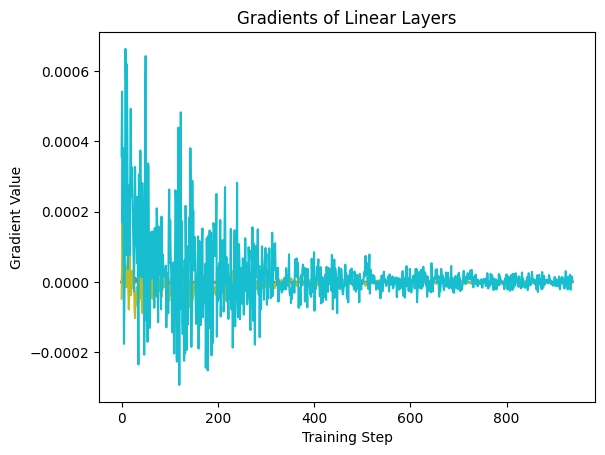

In [96]:
# Визуализируйте градиент:
fc_gradients_cpu = torch.Tensor(fc_gradients, device="cpu")
plt.plot(fc_gradients)
plt.title("Gradients of Linear Layers")
plt.xlabel("Training Step")
plt.ylabel("Gradient Value")
plt.show()

Как видите, после примерно 300 итерации градиент начал *затухать*, что означает, что веса скрытых слоев перестали обучаться. По этой причине лосс и перестал уменьшаться, т.к. градиент стал слишком мал чтобы влиять на веса слоев.

Глубокие модели (с большим числом скрытых слоев) подвержены проблеме затухания градиента, что приводит к тому, что такие модели не могут обучаться эффективно. 

Одна из причин этого (в этом примере) это использования sigmoid в качестве функции активации. Давайте изменим функцию активации на ReLU и переобучим модель еще раз.

**Задача 5:** Замените sigmoid на ReLU

In [134]:
# Замените sigmoid на ReLU:
class DeepMLP_ReLU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_hidden):
        super(DeepMLP_ReLU, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_hidden)])
        self.output_layer = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.input_layer(x)
        for hidden_layer in self.hidden_layers:
            x = F.relu(hidden_layer(x))
        x = self.output_layer(x)
        return x

**Вопрос:** Посчитайте и выведите сумму всех выходов модели для рандмного входного тензора test_input

**Пример ответа:** `0.234`

In [135]:
# Инициализируйте модель с ReLU:
torch.manual_seed(42)

input_size = 28 * 28
hidden_size = 32
output_size = 10
n_hidden=10
model_relu = DeepMLP_ReLU(input_size, hidden_size, output_size, n_hidden).to(device)

In [136]:
torch.manual_seed(42)
test_input = torch.rand(1, 28*28).to(device)
answer = model(test_input).sum()
answer   ### здесь должен быть выведен ответ

tensor(-1.2736, grad_fn=<SumBackward0>)

In [101]:
# Обучите модель с ReLU:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_relu.parameters(), lr=0.01)

fc_gradients = train(model_relu, trainloader, criterion, optimizer)

  0%|          | 1/938 [00:03<59:19,  3.80s/it]

Step: 0, Loss: 2.303701162338257


  3%|▎         | 25/938 [00:04<01:14, 12.32it/s]

Step: 10, Loss: 2.2954559326171875
Step: 20, Loss: 2.302825689315796
Step: 30, Loss: 2.304784059524536


  6%|▋         | 59/938 [00:04<00:22, 39.50it/s]

Step: 40, Loss: 2.269397020339966
Step: 50, Loss: 2.288856029510498


  9%|▊         | 80/938 [00:04<00:14, 58.31it/s]

Step: 60, Loss: 2.1842076778411865
Step: 70, Loss: 1.937113881111145


 11%|█         | 101/938 [00:05<00:11, 74.85it/s]

Step: 80, Loss: 1.9352937936782837
Step: 90, Loss: 1.8628398180007935
Step: 100, Loss: 1.8116354942321777


 13%|█▎        | 124/938 [00:05<00:09, 89.59it/s]

Step: 110, Loss: 1.9286977052688599
Step: 120, Loss: 1.6434870958328247
Step: 130, Loss: 1.6418001651763916


 17%|█▋        | 158/938 [00:05<00:07, 99.16it/s]

Step: 140, Loss: 1.4904757738113403
Step: 150, Loss: 1.4902141094207764
Step: 160, Loss: 1.4175161123275757


 19%|█▉        | 180/938 [00:05<00:07, 100.44it/s]

Step: 170, Loss: 1.4738481044769287
Step: 180, Loss: 1.37649667263031
Step: 190, Loss: 1.168605089187622


 23%|██▎       | 215/938 [00:06<00:06, 105.38it/s]

Step: 200, Loss: 1.1800941228866577
Step: 210, Loss: 1.560613989830017
Step: 220, Loss: 1.2398308515548706


 27%|██▋       | 250/938 [00:06<00:06, 105.03it/s]

Step: 230, Loss: 1.2166121006011963
Step: 240, Loss: 1.2159432172775269


 28%|██▊       | 261/938 [00:06<00:06, 104.38it/s]

Step: 250, Loss: 1.270929217338562
Step: 260, Loss: 1.081102967262268


 30%|███       | 283/938 [00:06<00:07, 85.96it/s] 

Step: 270, Loss: 1.3342819213867188
Step: 280, Loss: 1.235337257385254


 33%|███▎      | 305/938 [00:07<00:06, 94.04it/s]

Step: 290, Loss: 1.3854856491088867
Step: 300, Loss: 1.8118293285369873
Step: 310, Loss: 1.4462839365005493


 36%|███▌      | 337/938 [00:07<00:06, 96.39it/s]

Step: 320, Loss: 1.7309645414352417
Step: 330, Loss: 1.4237140417099
Step: 340, Loss: 1.3741377592086792


 39%|███▉      | 369/938 [00:07<00:05, 101.77it/s]

Step: 350, Loss: 1.2878779172897339
Step: 360, Loss: 1.1528854370117188
Step: 370, Loss: 1.322199821472168


 42%|████▏     | 391/938 [00:07<00:05, 100.10it/s]

Step: 380, Loss: 1.1030904054641724
Step: 390, Loss: 1.1437404155731201


 44%|████▍     | 413/938 [00:08<00:05, 100.81it/s]

Step: 400, Loss: 1.2408814430236816
Step: 410, Loss: 1.2835272550582886
Step: 420, Loss: 1.1757066249847412


 48%|████▊     | 446/938 [00:08<00:04, 99.65it/s] 

Step: 430, Loss: 1.1570967435836792
Step: 440, Loss: 1.1619206666946411


 50%|████▉     | 467/938 [00:08<00:04, 97.05it/s]

Step: 450, Loss: 0.9987881779670715
Step: 460, Loss: 1.40483820438385
Step: 470, Loss: 0.7472517490386963


 53%|█████▎    | 497/938 [00:09<00:04, 96.62it/s]

Step: 480, Loss: 1.0403451919555664
Step: 490, Loss: 1.0840520858764648
Step: 500, Loss: 1.0136277675628662


 56%|█████▋    | 529/938 [00:09<00:04, 99.06it/s]

Step: 510, Loss: 1.0599125623703003
Step: 520, Loss: 1.1859945058822632


 59%|█████▊    | 549/938 [00:09<00:04, 97.12it/s]

Step: 530, Loss: 1.1782035827636719
Step: 540, Loss: 0.8622666597366333


 60%|█████▉    | 559/938 [00:09<00:04, 83.47it/s]

Step: 550, Loss: 0.9618480801582336
Step: 560, Loss: 0.8986835479736328


 62%|██████▏   | 580/938 [00:09<00:03, 89.51it/s]

Step: 570, Loss: 1.3286861181259155
Step: 580, Loss: 1.055467128753662


 64%|██████▍   | 601/938 [00:10<00:03, 92.98it/s]

Step: 590, Loss: 1.3428422212600708
Step: 600, Loss: 0.9904097318649292
Step: 610, Loss: 0.9097793698310852


 68%|██████▊   | 642/938 [00:10<00:03, 97.20it/s]

Step: 620, Loss: 0.9475706815719604
Step: 630, Loss: 1.576300859451294
Step: 640, Loss: 0.8908309936523438


 71%|███████   | 662/938 [00:10<00:02, 93.83it/s]

Step: 650, Loss: 0.8466775417327881
Step: 660, Loss: 1.0996437072753906


 73%|███████▎  | 682/938 [00:11<00:02, 95.50it/s]

Step: 670, Loss: 0.9365435838699341
Step: 680, Loss: 1.2351508140563965


 75%|███████▍  | 702/938 [00:11<00:02, 87.94it/s]

Step: 690, Loss: 1.42799711227417
Step: 700, Loss: 1.233328104019165


 78%|███████▊  | 729/938 [00:11<00:02, 85.92it/s]

Step: 710, Loss: 0.9556259512901306
Step: 720, Loss: 1.0622268915176392


 79%|███████▊  | 738/938 [00:11<00:02, 85.38it/s]

Step: 730, Loss: 1.2589950561523438
Step: 740, Loss: 1.1168276071548462


 82%|████████▏ | 765/938 [00:12<00:02, 85.60it/s]

Step: 750, Loss: 1.1172305345535278
Step: 760, Loss: 1.9365497827529907


 84%|████████▎ | 785/938 [00:12<00:01, 88.28it/s]

Step: 770, Loss: 1.4260354042053223
Step: 780, Loss: 1.4854129552841187


 85%|████████▍ | 796/938 [00:12<00:01, 93.05it/s]

Step: 790, Loss: 1.5322375297546387
Step: 800, Loss: 1.357391357421875


 88%|████████▊ | 826/938 [00:12<00:01, 86.82it/s]

Step: 810, Loss: 1.295206904411316
Step: 820, Loss: 1.2917392253875732


 90%|█████████ | 846/938 [00:12<00:01, 88.81it/s]

Step: 830, Loss: 1.6717957258224487
Step: 840, Loss: 1.6585474014282227


 92%|█████████▏| 866/938 [00:13<00:00, 91.16it/s]

Step: 850, Loss: 1.8011767864227295
Step: 860, Loss: 1.3011175394058228


 94%|█████████▍| 886/938 [00:13<00:00, 89.56it/s]

Step: 870, Loss: 1.3097299337387085
Step: 880, Loss: 1.2571336030960083


 96%|█████████▋| 905/938 [00:13<00:00, 88.66it/s]

Step: 890, Loss: 1.2771086692810059
Step: 900, Loss: 1.4879400730133057


 98%|█████████▊| 923/938 [00:13<00:00, 87.77it/s]

Step: 910, Loss: 1.3494266271591187
Step: 920, Loss: 1.173296570777893


 99%|█████████▉| 932/938 [00:13<00:00, 87.72it/s]

Step: 930, Loss: 1.3522974252700806


100%|██████████| 938/938 [00:15<00:00, 61.99it/s]


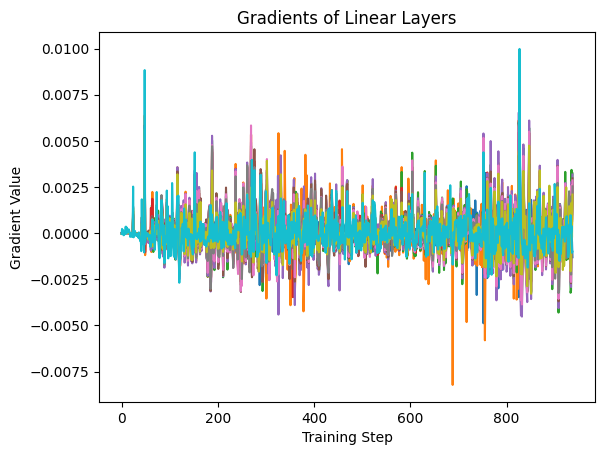

In [103]:
# Визуализируйте градинте:
plt.plot(fc_gradients)
#plt.legend()
plt.title("Gradients of Linear Layers")
plt.xlabel("Training Step")
plt.ylabel("Gradient Value")
plt.show()

Вы должны получить лосс в диапазоне 1.3-1.6. Проблема затухания градиента должна уменьшится, но не решиться полностью. Обучение глубоких нейронных сетей является нетривиальной задачей!

# Проблема взрыва градиента

Это проблема противоположна предыдущей. Вместо стремления градиента к 0, и потери способности изменять веса слоев (а значит и обучаться), градиент может "взорваться" (его значения стремятся к большим числам), что приводит к очень большим и резким изменениям весов модели, не позволяя модели сходиться.

**Задача 6:** Инициализируйте модель еще раз со следующими входными параметрами.

In [104]:
torch.manual_seed(42)

# Инициализация модели, лосс функции и оптимайзера:
input_size = 28 * 28 # MNIST image size
hidden_size = 512
output_size = 10
n_hidden=20
model = DeepMLP(input_size, hidden_size, output_size, n_hidden).to(device)

**Вопрос:** Посчитайте и выведите сумму всех выходов модели для рандмного входного тензора test_input (да да, еще раз)

**Пример ответа:** `0.234`

In [105]:
torch.manual_seed(42)
test_input = torch.rand(1, 28*28).to(device)
answer = model(test_input).sum()
answer   ### здесь должен быть выведен ответ

-0.9367366433143616

In [106]:
# Обучите модель еще раз:
torch.manual_seed(42)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

fc_gradients = train(model, trainloader, criterion, optimizer)

  0%|          | 1/938 [00:03<1:01:14,  3.92s/it]

Step: 0, Loss: 2.370612144470215


  1%|▏         | 14/938 [00:04<02:08,  7.18it/s] 

Step: 10, Loss: 2.319352149963379


  3%|▎         | 26/938 [00:04<00:53, 16.94it/s]

Step: 20, Loss: 2.384559392929077


  4%|▎         | 34/938 [00:05<00:39, 23.12it/s]

Step: 30, Loss: 2.322371482849121


  5%|▍         | 46/938 [00:05<00:30, 29.32it/s]

Step: 40, Loss: 2.3334953784942627


  6%|▌         | 54/938 [00:05<00:28, 31.36it/s]

Step: 50, Loss: 2.335846185684204


  7%|▋         | 66/938 [00:06<00:26, 32.64it/s]

Step: 60, Loss: 2.337700843811035


  8%|▊         | 74/938 [00:06<00:26, 32.44it/s]

Step: 70, Loss: 2.2949419021606445


  9%|▉         | 86/938 [00:06<00:25, 33.23it/s]

Step: 80, Loss: 2.3135998249053955


 10%|█         | 94/938 [00:06<00:26, 32.33it/s]

Step: 90, Loss: 2.3037657737731934


 11%|█         | 104/938 [00:07<00:29, 27.89it/s]

Step: 100, Loss: 2.3035051822662354


 12%|█▏        | 115/938 [00:07<00:27, 30.48it/s]

Step: 110, Loss: 2.311680316925049


 14%|█▎        | 127/938 [00:08<00:25, 31.64it/s]

Step: 120, Loss: 2.2950570583343506


 14%|█▍        | 135/938 [00:08<00:25, 31.62it/s]

Step: 130, Loss: 2.2916626930236816


 16%|█▌        | 147/938 [00:08<00:23, 33.14it/s]

Step: 140, Loss: 2.30366849899292


 17%|█▋        | 155/938 [00:08<00:24, 32.17it/s]

Step: 150, Loss: 2.308088541030884


 18%|█▊        | 167/938 [00:09<00:23, 32.28it/s]

Step: 160, Loss: 2.294508695602417


 19%|█▊        | 175/938 [00:09<00:26, 28.30it/s]

Step: 170, Loss: 2.29966139793396


 20%|█▉        | 187/938 [00:10<00:24, 30.82it/s]

Step: 180, Loss: 2.30952787399292


 21%|██        | 195/938 [00:10<00:25, 28.91it/s]

Step: 190, Loss: 2.3046488761901855


 22%|██▏       | 205/938 [00:10<00:24, 30.04it/s]

Step: 200, Loss: 2.2925260066986084


 23%|██▎       | 217/938 [00:11<00:23, 31.16it/s]

Step: 210, Loss: 2.297971487045288


 24%|██▍       | 225/938 [00:11<00:23, 30.09it/s]

Step: 220, Loss: 2.3187084197998047


 25%|██▌       | 236/938 [00:11<00:23, 30.14it/s]

Step: 230, Loss: 2.296956777572632


 26%|██▌       | 244/938 [00:11<00:22, 30.35it/s]

Step: 240, Loss: 2.320816993713379


 27%|██▋       | 256/938 [00:12<00:21, 31.10it/s]

Step: 250, Loss: 2.3015005588531494


 28%|██▊       | 264/938 [00:12<00:21, 31.11it/s]

Step: 260, Loss: 2.3070170879364014


 29%|██▉       | 276/938 [00:12<00:21, 30.87it/s]

Step: 270, Loss: 2.304478406906128


 30%|██▉       | 280/938 [00:13<00:21, 30.30it/s]

Step: 280, Loss: 2.3052570819854736


 31%|███▏      | 295/938 [00:13<00:22, 28.43it/s]

Step: 290, Loss: 2.3059656620025635


 33%|███▎      | 306/938 [00:14<00:21, 29.76it/s]

Step: 300, Loss: 2.3120129108428955


 34%|███▎      | 316/938 [00:14<00:20, 29.90it/s]

Step: 310, Loss: 2.291264057159424


 35%|███▍      | 325/938 [00:14<00:20, 29.21it/s]

Step: 320, Loss: 2.298677682876587


 36%|███▌      | 334/938 [00:15<00:21, 28.75it/s]

Step: 330, Loss: 2.296095609664917


 37%|███▋      | 347/938 [00:15<00:20, 29.44it/s]

Step: 340, Loss: 2.305849075317383


 38%|███▊      | 357/938 [00:15<00:19, 29.66it/s]

Step: 350, Loss: 2.3076016902923584


 39%|███▉      | 366/938 [00:16<00:19, 29.32it/s]

Step: 360, Loss: 2.2834115028381348


 40%|████      | 376/938 [00:16<00:19, 29.43it/s]

Step: 370, Loss: 2.29878830909729


 41%|████      | 386/938 [00:16<00:18, 30.24it/s]

Step: 380, Loss: 2.303243398666382


 42%|████▏     | 393/938 [00:17<00:22, 24.07it/s]

Step: 390, Loss: 2.301693916320801


 43%|████▎     | 403/938 [00:17<00:19, 27.87it/s]

Step: 400, Loss: 2.3153209686279297


 44%|████▍     | 414/938 [00:17<00:18, 29.00it/s]

Step: 410, Loss: 2.3035590648651123


 45%|████▌     | 424/938 [00:18<00:17, 29.06it/s]

Step: 420, Loss: 2.306708812713623


 47%|████▋     | 437/938 [00:18<00:17, 29.31it/s]

Step: 430, Loss: 2.301382303237915


 47%|████▋     | 443/938 [00:18<00:17, 28.63it/s]

Step: 440, Loss: 2.309920310974121


 49%|████▊     | 457/938 [00:19<00:16, 28.95it/s]

Step: 450, Loss: 2.3080391883850098


 49%|████▉     | 463/938 [00:19<00:16, 28.88it/s]

Step: 460, Loss: 2.2981135845184326


 51%|█████     | 474/938 [00:19<00:15, 29.23it/s]

Step: 470, Loss: 2.296691656112671


 51%|█████▏    | 483/938 [00:20<00:15, 28.79it/s]

Step: 480, Loss: 2.2905993461608887


 53%|█████▎    | 493/938 [00:20<00:15, 28.76it/s]

Step: 490, Loss: 2.301241636276245


 54%|█████▍    | 506/938 [00:21<00:15, 27.66it/s]

Step: 500, Loss: 2.303941488265991


 55%|█████▍    | 515/938 [00:21<00:15, 28.04it/s]

Step: 510, Loss: 2.305436611175537


 56%|█████▌    | 524/938 [00:21<00:15, 27.58it/s]

Step: 520, Loss: 2.295976161956787


 57%|█████▋    | 533/938 [00:22<00:14, 27.77it/s]

Step: 530, Loss: 2.29780912399292


 58%|█████▊    | 546/938 [00:22<00:13, 28.56it/s]

Step: 540, Loss: 2.3027031421661377


 59%|█████▉    | 555/938 [00:22<00:13, 28.19it/s]

Step: 550, Loss: 2.3001861572265625


 60%|██████    | 564/938 [00:23<00:13, 28.30it/s]

Step: 560, Loss: 2.296241283416748


 61%|██████    | 573/938 [00:23<00:13, 28.03it/s]

Step: 570, Loss: 2.310544967651367


 62%|██████▏   | 585/938 [00:23<00:13, 26.13it/s]

Step: 580, Loss: 2.303436756134033


 63%|██████▎   | 594/938 [00:24<00:12, 26.96it/s]

Step: 590, Loss: 2.3133819103240967


 65%|██████▍   | 606/938 [00:24<00:12, 25.78it/s]

Step: 600, Loss: 2.293776750564575


 66%|██████▌   | 615/938 [00:25<00:11, 26.99it/s]

Step: 610, Loss: 2.318946123123169


 67%|██████▋   | 624/938 [00:25<00:11, 27.37it/s]

Step: 620, Loss: 2.3001785278320312


 67%|██████▋   | 633/938 [00:25<00:10, 27.80it/s]

Step: 630, Loss: 2.309185028076172


 69%|██████▉   | 645/938 [00:26<00:10, 28.72it/s]

Step: 640, Loss: 2.285482168197632


 70%|██████▉   | 654/938 [00:26<00:10, 28.08it/s]

Step: 650, Loss: 2.299595355987549


 71%|███████   | 666/938 [00:26<00:09, 28.16it/s]

Step: 660, Loss: 2.3087778091430664


 72%|███████▏  | 675/938 [00:27<00:09, 27.48it/s]

Step: 670, Loss: 2.292626142501831


 73%|███████▎  | 684/938 [00:27<00:09, 26.91it/s]

Step: 680, Loss: 2.312490224838257


 74%|███████▍  | 696/938 [00:28<00:08, 27.86it/s]

Step: 690, Loss: 2.3027215003967285


 75%|███████▌  | 705/938 [00:28<00:08, 27.40it/s]

Step: 700, Loss: 2.3031020164489746


 76%|███████▌  | 714/938 [00:28<00:08, 25.15it/s]

Step: 710, Loss: 2.2977705001831055


 77%|███████▋  | 726/938 [00:29<00:07, 26.67it/s]

Step: 720, Loss: 2.310284376144409


 78%|███████▊  | 735/938 [00:29<00:07, 26.86it/s]

Step: 730, Loss: 2.3078012466430664


 79%|███████▉  | 744/938 [00:29<00:07, 27.54it/s]

Step: 740, Loss: 2.294431447982788


 81%|████████  | 756/938 [00:30<00:06, 27.16it/s]

Step: 750, Loss: 2.2965087890625


 82%|████████▏ | 765/938 [00:30<00:06, 27.38it/s]

Step: 760, Loss: 2.3016974925994873


 83%|████████▎ | 774/938 [00:30<00:06, 25.29it/s]

Step: 770, Loss: 2.315286636352539


 84%|████████▍ | 786/938 [00:31<00:05, 26.99it/s]

Step: 780, Loss: 2.292430877685547


 85%|████████▍ | 796/938 [00:31<00:04, 28.48it/s]

Step: 790, Loss: 2.2961673736572266


 86%|████████▌ | 805/938 [00:32<00:04, 27.76it/s]

Step: 800, Loss: 2.2978835105895996


 87%|████████▋ | 814/938 [00:32<00:05, 24.61it/s]

Step: 810, Loss: 2.3135786056518555


 88%|████████▊ | 826/938 [00:32<00:04, 26.22it/s]

Step: 820, Loss: 2.307420015335083


 89%|████████▉ | 835/938 [00:33<00:03, 26.77it/s]

Step: 830, Loss: 2.3165266513824463


 90%|████████▉ | 844/938 [00:33<00:03, 27.21it/s]

Step: 840, Loss: 2.305375814437866


 91%|█████████▏| 856/938 [00:34<00:03, 27.04it/s]

Step: 850, Loss: 2.3068714141845703


 92%|█████████▏| 865/938 [00:34<00:02, 26.78it/s]

Step: 860, Loss: 2.3002524375915527


 93%|█████████▎| 874/938 [00:34<00:02, 26.70it/s]

Step: 870, Loss: 2.2848072052001953


 94%|█████████▍| 886/938 [00:35<00:01, 26.72it/s]

Step: 880, Loss: 2.3027474880218506


 95%|█████████▌| 895/938 [00:35<00:01, 27.49it/s]

Step: 890, Loss: 2.299281120300293


 96%|█████████▋| 905/938 [00:35<00:01, 27.64it/s]

Step: 900, Loss: 2.303833246231079


 97%|█████████▋| 914/938 [00:36<00:00, 24.85it/s]

Step: 910, Loss: 2.2965757846832275


 99%|█████████▊| 926/938 [00:36<00:00, 27.02it/s]

Step: 920, Loss: 2.298959732055664


100%|█████████▉| 935/938 [00:37<00:00, 27.99it/s]

Step: 930, Loss: 2.294468879699707


100%|██████████| 938/938 [00:38<00:00, 24.63it/s]


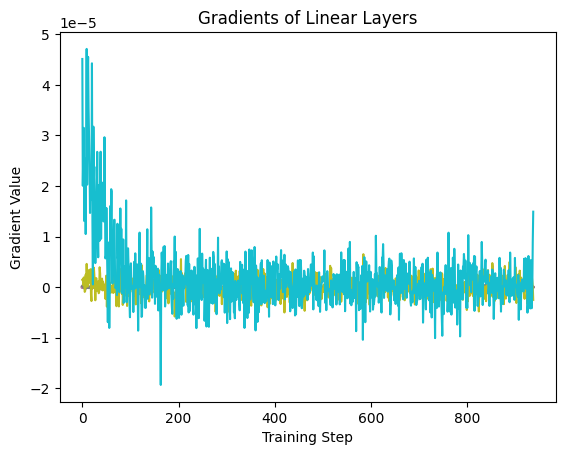

In [107]:
# Визуализируйте градиент:
plt.plot(fc_gradients)
#plt.legend()
plt.title("Gradients of Linear Layers")
plt.xlabel("Training Step")
plt.ylabel("Gradient Value")
plt.show()

Как видите, магнитуда градиента стала слишком большой, что приводит к тому, что модель не может сойтись (достичь минимума).

# ResNet

Теперь давайте попробуем реализовать модель ResNet. Ее авторы нашли способ как бороться с проблемой затухания градиента в глубоких сетях используя так называемые shortcut (или residual) связи между слоями.

**Задача 7:** Определите Residual Block

In [108]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride), nn.BatchNorm2d(out_channels))

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

**Вопрос:** Посчитайте и выведите сумму выходов ResidualBlock(10,10) для рандомного входного тензора test_input.

**Пример ответа:** `1.234`

In [109]:
torch.manual_seed(42)
test_input = torch.rand((1, 10, 3, 28*28))
res_block = ResidualBlock(10, 10)
answer = res_block(test_input).sum()
answer   ### здесь должен быть выведен ответ

tensor(16789.0645, grad_fn=<SumBackward0>)

**Задача 8:** Теперь определите модель ResNet, состоящую из нескольких ResidualBlock

In [110]:
class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.layer1 = self._make_layer(64, 64, 2)
        self.layer2 = self._make_layer(64, 128, 2)
        self.layer3 = self._make_layer(128, 256, 2)
        self.fc = nn.Linear(2304, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride=1):
        layers = []
        for i in range(num_blocks):
            if i == 0:
                layers.append(ResidualBlock(in_channels, out_channels, stride))
            else:
                layers.append(ResidualBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

**Вопрос:** Посчитайте и выведите количество параметров (весов) этой ResNet модели

**Пример ответа:** `43242`

In [137]:
model = ResNet()
answer = sum(p.numel() for p in model.parameters() if p.requires_grad)
answer   ### здесь должен быть выведен ответ

2799114

In [ ]:
# Инициализируем объект класса модели ResNet, а также лосс функцию и оптимайзер:
torch.manual_seed(42)

model = ResNet().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [138]:
# Теперь обучите эту модель:
torch.manual_seed(42)

model.train()

fc_gradients = []

for step, data in tqdm(enumerate(trainloader), total=len(trainloader)):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    loss.backward()
    optimizer.step()

    if step % 10 == 0:
      print(f'Step: {step}, Loss: {loss}')

    fc_gradients.append(model.fc.weight.grad.mean().item())

  0%|          | 1/938 [00:08<2:06:15,  8.09s/it]

Step: 0, Loss: 2.673649787902832


  1%|          | 11/938 [00:55<1:15:02,  4.86s/it]

Step: 10, Loss: 2.3781251907348633


  2%|▏         | 21/938 [01:58<1:54:16,  7.48s/it]

Step: 20, Loss: 2.545574426651001


  2%|▏         | 22/938 [02:06<1:28:02,  5.77s/it]


KeyboardInterrupt: 

Как можете видеть, лосс продолжает уменьшаться. Теперь попробуйте визиулизировать градиент накопленный в переменной fc_gradients

In [ ]:
# Визуализируйте градиент:
plt.plot(fc_gradients)
plt.legend()
plt.title("Gradients of Linear Layers")
plt.xlabel("Training Step")
plt.ylabel("Gradient Value")
plt.show()

Теперь градиент кажется достаточно стабильным, и это позволяет ResNet модели обучаться лучше предыдущей модели, которая была подвержена проблеме затухания градента. Таким способом ResNet стала SOTA моделью в 2015 году и выиграла ImageNet competition.

Наконец, давайте сохраним параметры (веса) обученной модели чтобы переиспользовать их позже:

In [145]:
checkpoint_path = './mnist_checkpoint.pth'
torch.save(model.state_dict(), checkpoint_path)

# Transfer Learning

Перед тем как мы перейдем к технике обучения называемой Transfer Learning, давайте сперва протестируем нашу модель на тестовой подвыборке датасета MNIST. Чтобы сделать это, вам необходимо скачать тестовую подвыборку схожим образом, как вы уже скачали подвыборку для обучения с тем отличием, что нужно изменить параметр `train=False`:

In [142]:
# Загрузите тестовую подвыборку датасета MNIST:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

Теперь нам нужно имплементировать функцию для тестирования модели, в которой мы будем считать точность (accuracy) нашей модели (т.е. процент правильных предсказаний):

In [143]:
def test(model, dataloader):
  model.eval()

  with torch.no_grad():
    correct = 0

    for step, data in tqdm(enumerate(dataloader), total=len(dataloader)):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()
        
    accuracy = correct/len(dataloader.dataset)

    return accuracy

Теперь загрузите ранее сохраненные параметры (веса) обученной ResNet модели:

**Задача 9:** Посчитайте точность модели на тесте.

In [146]:
model = ResNet()
model.load_state_dict(torch.load(checkpoint_path))
model = model.to(device)

**Вопрос:** Посчитайте и выведите точность модели на тестовой выборке MNIST.

**Пример ответа:** `22.45`

In [ ]:
accuracy = test(model=model, dataloader=testloader)
print(f"\nMNIST test accuracy: {100*accuracy}%")  

Вы должны получить точность примерно 96% или выше.

Теперь давайте попробуем загрузить другой датасет - CIFAR10, который состоит из 10 классов, но содержит изображения не рукописаных цифр, а объектов (horses, dogs, cars, и др.). Изображения имеют размер 32x32 и три цветовых канала (RGB). Поэтому нам также нужно изменить трансформации (transforms), чтобы изображения CIFAR10 соответствовали  изображениям MNIST (т.е. 28x28 в формате grayscale):

In [ ]:
# Трансформации для датасета CIFAR10:
transform_cifar10 = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28,28)), 
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Выборка для обучения:
trainset_cifar10 = torchvision.datasets.CIFAR10(root='./data_cifar10', train=True, download=True, transform=transform_cifar10)
trainloader_cifar10 = torch.utils.data.DataLoader(trainset_cifar10, batch_size=64, shuffle=True, num_workers=2)

# Выборка для тестирования:
testset_cifar10 = torchvision.datasets.CIFAR10(root='./data_cifar10', train=False, download=True, transform=transform_cifar10)
testloader_cifar10 = torch.utils.data.DataLoader(testset_cifar10, batch_size=64, shuffle=False, num_workers=2)

Теперь протестируйте ранее обученную ResNet модель на тестовой выборке датасета CIFAR10 (пока переобучать модель не нужно!):

**Задача 10:** Протестируйте модель на тестовой выборке CIFAR10

**Вопрос:** Посчитайте и выведите точность модели на тесте

**Пример ответа:** `22.45`

In [ ]:
accuracy = # YOUR CODE HERE
print(f"\nTest accuracy: {100*accuracy}%")  

Как видите, точность на CIFAR10 не очень большая (около 10%). И это не удивительно, ведь мы обучали нашу ResNet модель на другом датасете (MNIST).

Теперь давайте заморозим все слои за исключением последнего (т.е. слоя классификации):

**Задача 11:** Заморозьте слои модели кроме последнего

In [ ]:
for param in model.parameters():
    param.requires_grad = False              # отключаем градиент (т.е. "замораживаем" слои)
    
mnist_fc = model.fc                          # Сохраняем в переменную слой классификации MNIST
in_features = model.fc.in_features         
model.fc = torch.nn.Linear(in_features, 10)  # Создаем новый слой классификации для CIFAR10
model.fc = model.fc.cuda()

**Вопрос:** Посчитайте и выведите количество параметров (весов) в замороженных слоях

**Пример ответа:** `224513`

In [ ]:
frozen_params = # YOUR CODE HERE
frozen_params   ### здесь должен быть выведен ответ

**Задача 12:** Обучите только последний слой модели на датасете CIFAR10 (все остальные слои должны быть заморожены)

In [ ]:
torch.manual_seed(42)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for step, data in tqdm(enumerate(trainloader_cifar10), total=len(trainloader_cifar10)):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    loss.backward()
    optimizer.step()

    if step % 10 == 0:
      print(f'Step: {step}, Loss: {loss}')

**Вопрос:** Посчитайте точность на тестовой выборке CIFAR10

**Пример ответа:** `32.45`

In [ ]:
accuracy = # YOUR CODE HERE
print(f"\nTest accuracy: {100*accuracy}%")   

Как можете видеть, точность модели выросла до примерно 35%. Мы обучили только последний слой (классификации), а остальная часть сети осталось нетронутой (т.е. остальные слои обучены на датасете MNIST). Эта техника обучения и называется Transfer Learning.

Теперь протестируйте эту модель еще раз на тестовой выборке MNIST:

In [ ]:
accuracy = test(model, testloader)
print(f"\nMNIST test accuracy: {100*accuracy}%")  

Как вы можете видеть, точность упала ниже 10%, поскольку последний слой классификации теперь обучен на CIFAR10 датасете. Это называется "катастрофическим забыванием" (catastrophic forgetting). Катастрофическое забывание это тенденация нейронной сети забывать предыдущие обученные знания когда она обучается новой информации.

Наконец, давайте вернем назад ранее сохраненный слой классификации обученный на MNIST и протестируем еще раз:

**Задача 13:** Верните последний слой mnist_fc и проведите финальный тест на тестовых выборках MNIST и CIFAR10

**Вопрос:** Посчитайте и выведите точность на тестовых выборках MNIST и CIFAR10

**Пример ответа:** 
`CIFAR test accuracy: 9.45`
`MNIST test accuracy: 51.68`

In [ ]:
model.fc =                                # верните в модель слой классификации обученный на MNIST
model.fc = model.fc.cuda()                # Перенесем на cuda

accuracy = test(model, testloader_cifar10)
print(f"\nCIFAR test accuracy: {100*accuracy}%")

accuracy = test(model, testloader)
print(f"\nMNIST test accuracy: {100*accuracy}%")  